# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
Ежемесячная плата: 550 рублей Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля сообщение: 3 рубля 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
Ежемесячная плата: 1950 рублей Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль сообщение: 1 рубль 1 Гб интернет-трафика: 150 рублей

### Обратите внимание:
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Загрузим датасеты

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Рассмотрим таблицу users

In [3]:
users.info()
users['user_id'].value_counts()
users['age'].unique()
print(users['tariff'].value_counts())
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
smart    351
ultra    149
Name: tariff, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Анализ данной таблицы показал:
1. Всего рассматривается 500 уникальных абонентов;
2. Дубликаты отсутствуют;
3. Ошибки в указании возраста отсутствуют;
4. Тарифа действительно только 2 - ультра и смарт, причем тарифом смарт пользуются примерно в 2 раза больше абонентов;
5. Тип данных в столбцах churn_date, reg_date необходимо изменены на datetime

## Рассмотрим таблицу tariffs

In [4]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Анализ данной таблицы показал:
1. Рассмотрено 2 тарифа - дешевый smart и дорогой ultra;
2. Типы данных верные;

## Рассмотрим таблицу calls

In [5]:
calls.info()
print(calls['user_id'].value_counts())
print(calls.query('duration == 0').count())
calls['duration'] = calls['duration'].replace(0, 1)
calls['duration_min'] = np.ceil(calls['duration'])
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64
id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64


,id,call_date,duration,user_id,duration_min
0,1000_0,2018-07-25,1.00,1000,1.0
1,1000_1,2018-08-17,1.00,1000,1.0
2,1000_2,2018-06-11,2.85,1000,3.0
3,1000_3,2018-09-21,13.80,1000,14.0
4,1000_4,2018-12-15,5.18,1000,6.0
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,1.0
202603,1499_216,2018-10-18,18.83,1499,19.0
202604,1499_217,2018-11-10,10.81,1499,11.0
202605,1499_218,2018-10-06,4.27,1499,5.0


Анализ данной таблицы показал:
1. Всего 202670 звонков;
2. Из 500 абонентов 8 не использовали звонки;
3. Больше 39613 звонков продолжительностью 0 минут. Данные звонки заменены на 1 минутные, т.к. тарификация по-минутная.
4. Продолжительности звонков округлены до минут и сведены в столбец 'duration_min'
5. Тип данных столбца call_date изменен в datetime;

## Рассмотрим таблицу internet

In [6]:
internet.info()
print(internet['user_id'].value_counts())
print(internet.sort_values(by = 'mb_used'))
internet['mb_used'] = internet['mb_used'].replace(0, 1)
internet['mb_used_r'] = np.ceil(internet['mb_used'])
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64
        Unnamed: 0        id  mb_used session_date  user_id
116616      116616  1393_102     0.00   2018-06-03     1393
53410        53410  1179_272     0.00   2018-08-11     1179
104303      104303  1353_239     0.00   2018-10-26     1353
19438        19438  1065_583     0.00   2018-03-26     1065
19437        19437  1065_582     0.00   2018-07-14     1065
...            ...       ...      ...          ...      ...
140299      140299  1471_182  1623.92   2

,Unnamed: 0,id,mb_used,session_date,user_id,mb_used_r
0,0,1000_0,112.95,2018-11-25,1000,113.0
1,1,1000_1,1052.81,2018-09-07,1000,1053.0
2,2,1000_2,1197.26,2018-06-25,1000,1198.0
3,3,1000_3,550.27,2018-08-22,1000,551.0
4,4,1000_4,302.56,2018-09-24,1000,303.0
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,319.0
149392,149392,1499_153,490.13,2018-12-14,1499,491.0
149393,149393,1499_154,1.00,2018-10-27,1499,1.0
149394,149394,1499_155,1246.32,2018-11-26,1499,1247.0


Анализ данной таблицы показал:
1. Всего 149396 заходов в интернет;
2. Из 500 абонентов 3 не использовали интернет;
3. Трафик 0 мегабайт заменен на 1 мегабайт.
4. Трафики округлены до целых и сведены в столбец 'duration_min'
3. Тип данных столбца session_date изменен в datetime;

## Рассмотрим таблицу messages

In [7]:
messages.info()
print(messages['user_id'].value_counts())
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


Анализ данной таблицы показал:
1. Всего 123036 смс;
2. Из 500 абонентов 74 не использовали смс;
3. Тип данных столбца message_date изменен в datetime;

## Расчеты

1. Рассчитаем количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам.
- В таблицы calls, internet, messages добавим столбец 'month' с указанием месяца;
- Сделаем сводники из данных таблиц с указанием 'user_id', 'month';
- Соберем данные в одну таблицу pivot по user_id;
2. Сведем все необходимые данные из таблиц users, tariffs и pivot в таблицу data.

In [8]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month
tariffs.columns = ['mess_inc', 'mb_inc', 'min_inc', 'rub', 'rub_gb', 'rub_mess', 'rub_min', 'tariff']
pivot_1 = (
    calls
    .pivot_table(index=('user_id', 'month'), values='duration_min', aggfunc='sum')
    .reset_index()
)
pivot_2 = (
    internet
    .pivot_table(index=('user_id', 'month'), values='mb_used_r', aggfunc='sum')
    .reset_index()
)
pivot_3 = (
    messages
    .pivot_table(index=('user_id', 'month'), values='id', aggfunc='count')
    .reset_index()
)
pivot = (
    pivot_1
    .merge(pivot_2, on=('user_id', 'month'), how='outer')
    .merge(pivot_3, on=('user_id', 'month'), how='outer')
)
pivot.columns = ['user_id', 'month', 'min', 'mb', 'mess']
data = (
    users[['user_id', 'city', 'tariff']]
    .merge(pivot, on=('user_id'), how='outer')
    .merge(tariffs, on=('tariff'), how='outer')
)
data


,user_id,city,tariff,month,min,mb,mess,mess_inc,mb_inc,min_inc,rub,rub_gb,rub_mess,rub_min
0,1000,Краснодар,ultra,5.0,164.0,2257.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6.0,187.0,23262.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7.0,346.0,14017.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8.0,418.0,14072.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9.0,478.0,14583.0,57.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,Владикавказ,smart,10.0,258.0,20614.0,42.0,50,15360,500,550,200,3,3
3212,1499,Пермь,smart,9.0,71.0,1849.0,11.0,50,15360,500,550,200,3,3
3213,1499,Пермь,smart,10.0,473.0,17824.0,48.0,50,15360,500,550,200,3,3
3214,1499,Пермь,smart,11.0,624.0,17994.0,59.0,50,15360,500,550,200,3,3


## Выручка
Рассчитанную выручку по месяцам для каждого абонента добавим в общую таблицу в столбец 'revenue'

In [9]:
def revenue(row):
    import math
    minute = row['min']
    mb = row['mb']
    mess = row['mess']
    mess_inc = row['mess_inc']
    mb_inc = row['mb_inc']
    min_inc = row['min_inc']
    rub = row['rub']
    rub_gb = row['rub_gb']
    rub_mess = row['rub_mess']
    rub_min = row['rub_min']
    rev = rub
    if (minute - min_inc) > 0:
        rev += ((minute - min_inc) * rub_min)
    if (mb - mb_inc) > 0:
        rev += (math.ceil((mb - mb_inc) / 1024) * rub_gb)
    if (mess - mess_inc) > 0:
        rev += ((mess - mess_inc) * rub_mess)
    return rev
data['revenue'] = data.apply(revenue, axis=1)
data

,user_id,city,tariff,month,min,mb,mess,mess_inc,mb_inc,min_inc,rub,rub_gb,rub_mess,rub_min,revenue
0,1000,Краснодар,ultra,5.0,164.0,2257.0,22.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,Краснодар,ultra,6.0,187.0,23262.0,60.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,Краснодар,ultra,7.0,346.0,14017.0,75.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,Краснодар,ultra,8.0,418.0,14072.0,81.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,Краснодар,ultra,9.0,478.0,14583.0,57.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,Владикавказ,smart,10.0,258.0,20614.0,42.0,50,15360,500,550,200,3,3,1750.0
3212,1499,Пермь,smart,9.0,71.0,1849.0,11.0,50,15360,500,550,200,3,3,550.0
3213,1499,Пермь,smart,10.0,473.0,17824.0,48.0,50,15360,500,550,200,3,3,1150.0
3214,1499,Пермь,smart,11.0,624.0,17994.0,59.0,50,15360,500,550,200,3,3,1549.0


# АНАЛИЗ ДАННЫХ

## Группировка данных по тарифам
Для удобства анализа создадим функцию, выводящую DataFrame по тарифу с указанием среднего, дисперсии и стандартного отклонения для продолжительности разговора, интернет-трафика и количества сообщений

In [10]:
info_smart = data.query('tariff == "smart"')
info_ultra = data.query('tariff == "ultra"')
def info(row):
    mean = row[['min', 'mb', 'mess']].mean()
    min_var = np.var(row[['min', 'mb', 'mess']])
    min_std = np.std(row[['min', 'mb', 'mess']])
    y = pd.DataFrame({
    'Среднее': mean,
    'Дисперсия': min_var,
    'Стд_откл': min_std,   
    })
    return y.reset_index()

## Тариф smart

In [11]:
h = info(info_smart)

## Тариф ultra

In [12]:
info(info_ultra)

,index,Среднее,Дисперсия,Стд_откл
0,min,560.113565,9.895847e+04,314.576647
1,mb,19688.587692,9.895724e+07,9947.725157
2,mess,61.161006,2.107006e+03,45.902130


## Гистограмма звонков

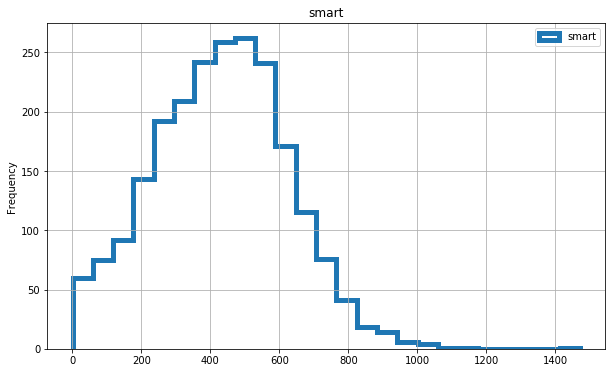

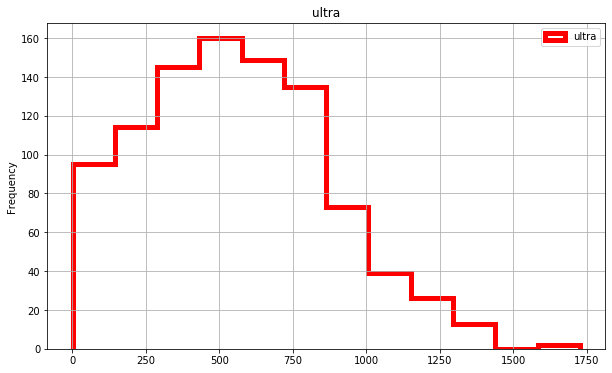

In [13]:
import matplotlib.pyplot as plt
info_smart.plot(kind='hist', y='min', histtype='step', bins=25, linewidth=5, label='smart', grid=True, figsize=(10, 6), title='smart')
plt.show()
info_ultra.plot(kind='hist', y='min', histtype='step', bins=12, linewidth=5, label='ultra', grid=True, figsize=(10, 6), color='red', title='ultra')
plt.show()


In [14]:
info_smart

,user_id,city,tariff,month,min,mb,mess,mess_inc,mb_inc,min_inc,rub,rub_gb,rub_mess,rub_min,revenue
986,1001,Москва,smart,11.0,444.0,18460.0,NaN,50,15360,500,550,200,3,3,1350.0
987,1001,Москва,smart,12.0,430.0,14059.0,NaN,50,15360,500,550,200,3,3,550.0
988,1002,Стерлитамак,smart,6.0,118.0,10878.0,4.0,50,15360,500,550,200,3,3,550.0
989,1002,Стерлитамак,smart,7.0,219.0,17615.0,11.0,50,15360,500,550,200,3,3,1150.0
990,1002,Стерлитамак,smart,8.0,294.0,20357.0,13.0,50,15360,500,550,200,3,3,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,Владикавказ,smart,10.0,258.0,20614.0,42.0,50,15360,500,550,200,3,3,1750.0
3212,1499,Пермь,smart,9.0,71.0,1849.0,11.0,50,15360,500,550,200,3,3,550.0
3213,1499,Пермь,smart,10.0,473.0,17824.0,48.0,50,15360,500,550,200,3,3,1150.0
3214,1499,Пермь,smart,11.0,624.0,17994.0,59.0,50,15360,500,550,200,3,3,1549.0


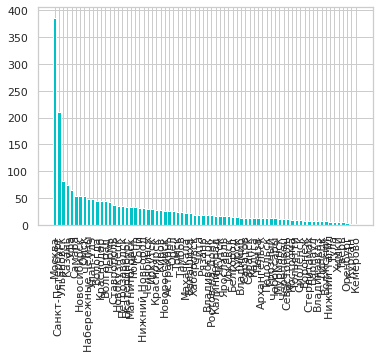

In [33]:
import seaborn as sns
sns.set(style="whitegrid")
fig, ax = plt.subplots()
d = ax.bar(info_smart['city'].value_counts().keys(), info_smart['city'].value_counts().values, color='#00c2c7')
ax.set_xticklabels(info_smart['city'].value_counts().keys(), rotation=90)
plt.show()

In [34]:
info_smart['city'].value_counts().keys()

Index(['Москва', 'Санкт-Петербург', 'Ульяновск', 'Казань', 'Уфа', 'Самара',
       'Новосибирск', 'Омск', 'Набережные Челны', 'Улан-Удэ', 'Вологда',
       'Краснодар', 'Волгоград', 'Пермь', 'Ставрополь', 'Новокузнецк',
       'Петрозаводск', 'Екатеринбург', 'Магнитогорск', 'Тюмень', 'Сочи',
       'Нижний Новгород', 'Челябинск', 'Иркутск', 'Красноярск', 'Киров',
       'Новороссийск', 'Астрахань', 'Орёл', 'Томск', 'Тамбов', 'Махачкала',
       'Балашиха', 'Хабаровск', 'Чита', 'Рязань', 'Владивосток',
       'Ростов-на-Дону', 'Калининград', 'Якутск', 'Ярославль', 'Ижевск',
       'Белгород', 'Курск', 'Владимир', 'Саратов', 'Саранск', 'Калуга',
       'Пенза', 'Архангельск', 'Подольск', 'Грозный', 'Чебоксары', 'Мурманск',
       'Череповец', 'Севастополь', 'Кострома', 'Тольятти', 'Смоленск',
       'Воронеж', 'Стерлитамак', 'Барнаул', 'Владикавказ', 'Липецк',
       'Волжский', 'Нижний Тагил', 'Тула', 'Химки', 'Тверь', 'Оренбург',
       'Курган', 'Кемерово'],
      dtype='object')

Анализ гистограмм и данных по звонкам показал:
1. Абоненты smart в среднем расходуют 430 минут звонков, абоненты ultra - 560. 
2. Большинство абонентов smart расходует от 150 до 700 минут, абонентов ultra - от 150 до 1000. Это говорит о том, что большому количеству абонентов smart не хватает тарифа и они вынуждены доплачивать за минуты сверх тарифа, абоненты ultra наоборот тратят менее половины минут тарифного плана.
3. Большое количество абонентов ultra не пользуются минутами.
4. Датасеты скошены влево.

## Гистограмма интернета

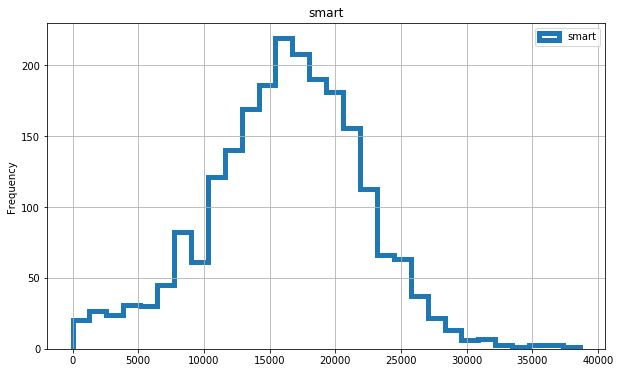

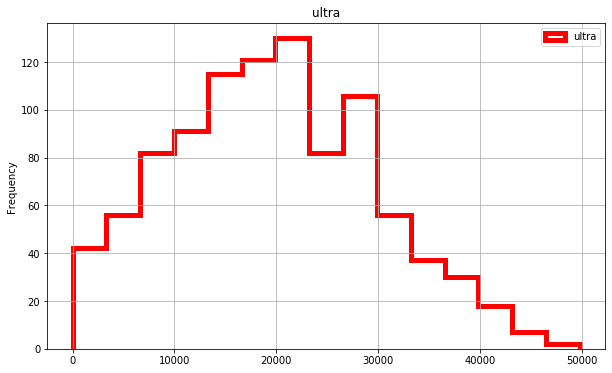

In [15]:
info_smart.plot(kind='hist', y='mb', histtype='step', bins=30, linewidth=5, label='smart', grid=True, figsize=(10, 6), title='smart')
plt.show()
info_ultra.plot(kind='hist', y='mb', histtype='step', bins=15, linewidth=5, label='ultra', grid=True, figsize=(10, 6), color='red', title='ultra')
plt.show()

Анализ гистограмм и данных по интернет-трафику показал:
1. Абоненты smart в среднем расходуют 16 Гбайт, абоненты ultra - 20. 
2. Большинство абонентов smart расходует от 7 до 27 Гбайт, абонентов ultra - от 5 до 40. Это говорит о том, что большому количеству абонентов smart не хватает тарифа и они вынуждены доплачивать за интернет сверх тарифа, среди абонентов ultra также есть те, кто перерасходует трафик.
3. Большое количество абонентов ultra не пользуются интернетом.
4. Датасеты скошены влево.

## Гистограмма сообщений

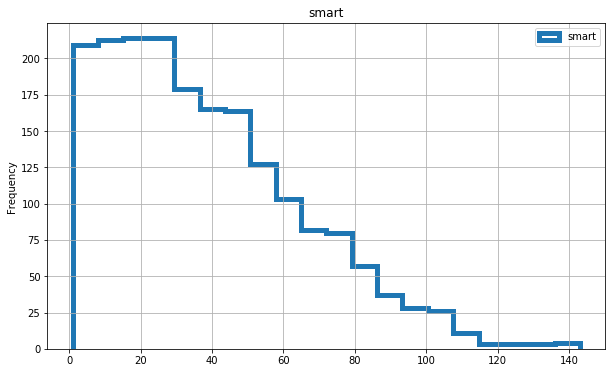

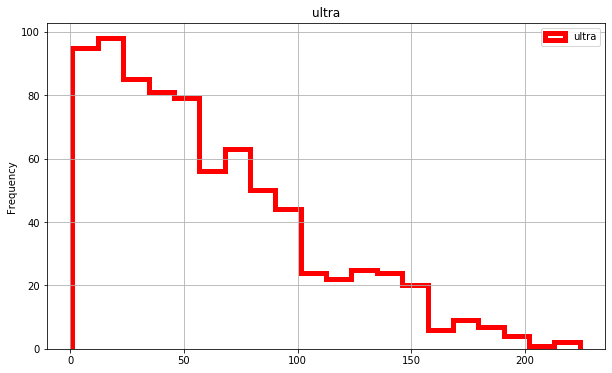

In [16]:
info_smart.plot(kind='hist', y='mess', histtype='step', bins=20, linewidth=5, label='smart', grid=True, figsize=(10, 6), title='smart')
plt.show()
info_ultra.plot(kind='hist', y='mess', histtype='step', bins=20, linewidth=5, label='ultra', grid=True, figsize=(10, 6), color='red', title='ultra')
plt.show()

Анализ гистограмм и данных по интернет-трафику показал:
1. Абоненты smart в среднем расходуют 40 смс, абоненты ultra - 60. 
2. Большинство абонентов smart расходует от 0 до 100 смс, абонентов ultra - от 0 до 170. Это говорит о том, что большому количеству абонентов smart не хватает тарифа и они вынуждены доплачивать за смс сверх тарифа, абоненты ultra наоборот тратят менее 1/5 смс тарифного плана.
3. Большое количество абонентов ultra и smart впринципе не пользуются интернетом.
4. Датасеты скошены влево.

# Проверка гипотез

## Гипотеза о различии тарифов по средней выручке
Нулевая гипотеза - средняя выручка тарифа «Ультра» равна тарифу «Смарт». 
Альтернативная гипотеза - средняя выручка тарифов «Ультра» и «Смарт» различается.

In [17]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')
print('Средняя выручка тарифа Смарт:', data_smart['revenue'].mean())
print('Средняя выручка тарифа Ультра:', data_ultra['revenue'].mean())
alpha = .05
results = st.ttest_ind(
    data_smart['revenue'], 
    data_ultra['revenue'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


Средняя выручка тарифа Смарт: 1312.1704035874438
Средняя выручка тарифа Ультра: 2070.943204868154
p-значение: 4.014178407919692e-149
Отвергаем нулевую гипотезу


Критерием оценки гипотезы служит уровень значимости p-value. Полученный уровень значимости говорит о том, что разница между средними выручками двух тарифов не случайна. Следовательно можно сказать, что средняя выручка тарифа Ультра больше средней выручки тарифа Смарт.

## Гипотеза о различии средней выручке в Москве и регионах
Нулевая гипотеза - средняя выручка в Москве равна выручке в других регионах. 
Альтернативная гипотеза - средняя выручка в Москве и других регионах различается

In [18]:
data_moscow = data.query('city == "Москва"')
data_region = data.query('city != "Москва"')
print('Средняя выручка в Москве:', data_moscow['revenue'].mean())
print('Средняя выручка в других регионах:', data_region['revenue'].mean())
alpha = .05
results = st.ttest_ind(
    data_moscow['revenue'], 
    data_region['revenue'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка в Москве: 1561.2209492635025
Средняя выручка в других регионах: 1540.9535508637236
p-значение: 0.5746021529115002
Не получилось отвергнуть нулевую гипотезу


Критерием оценки гипотезы служит уровень значимости p-value. Полученный уровень значимости говорит о том, что вероятность случайной разницы между средними выручками Москвы и регионов составляет 57%. Следовательно можно сказать, что средняя выручка в Москве равна выручке в регионах.

# Вывод

1. Многие абоненты тарифа Смарт расходуют минут, смс и интернет-трафика сверх тарифа. Необходимо предложить данным абонентам перейти на тариф Ультра, абоненты которого в основном укладываются в тарифные рамки.
2. Возможно следует разработать новый тариф, аналог Ультра, с уменьшением минут и смс, но увеличением интернет-трафика, который станет самым удобным и популярным. Например - 1000 минут, 200 смс, 50 Гбайт.
3. Средняя выручка тарифа Ультра существенно больше средней выручки Смарт. Требуется большая реклама и продвижение тарифа Ультра.
4. Средняя выручка в Москве равна выручке в регионах, следовательно необходимо равномерное продвижение в обоих направлениях.